# Link prediction

In [127]:
import pandas as pd
import math
import json

In [128]:
%matplotlib inline

## Run experiment

A dani_teszt_json.py fájlt futtatja

A paramétereket a config_test.json fájlban lehet változtatni

Ezek a ~/git/pyResSys/python/experiments útvonalon érhetők el

In [129]:
%%bash
pushd ~/git/pyRecSys
export LD_LIBRARY_PATH="$(pwd)/build"
export PYTHONPATH="$(pwd)/python"
popd
pushd ~/git/pyRecSys/python
echo $PYTHONPATH
source activate python3
python ./experiments/dani_teszt_json.py ./experiments/config_test.json
source deactivate
popd

~/git/pyRecSys ~/git/temporal-networks/linkpred
~/git/temporal-networks/linkpred
~/git/pyRecSys/python ~/git/temporal-networks/linkpred
/home/danielolah/git/pyRecSys/python
{'input_file': '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions_for_rec_0',
 'input_file_with3column': '/mnt/idms/temporalNodeRanking/data/filtered_timeline_data/tsv/15o/15o_only_first_mentions.csv',
 'learningRate': 0.05,
 'minTime': 1318244928,
 'negativeRate': 9,
 'output_file': '/home/danielolah/git/temporal-networks/linkpred/predicted_links',
 'timeFrame': 86400,
 'topK': 1000}
173582
reading data...
data reading finished
logging to file /home/danielolah/git/temporal-networks/linkpred/predicted_links.out
running experiment...
~/git/temporal-networks/linkpred


FactorModel's CamelCase parameters are DEPRECATED, use google code.
FactorModelGradientUpdater's CamelCase parameters are DEPRECATED, use google code.
FactorModelGradientUpdater::setModel is DEPRECATED, use google code.
run...
0%-1%-2%-3%-4%-5.001%-OnlinePredictor::predict computes prediction.
OnlinePredictor::predict done
6.001%-7.001%-8.001%-9.001%-10%-OnlinePredictor::predict computes prediction.
OnlinePredictor::predict done
11%-12%-13%-14%-15%-OnlinePredictor::predict computes prediction.
OnlinePredictor::predict done
16%-17%-18%-19%-20%-21%-OnlinePredictor::predict computes prediction.
OnlinePredictor::predict done
22%-23%-24%-25%-26%-27%-28%-29%-30%-31%-32%-33%-34%-35%-36%-37%-38%-39%-40%-OnlinePredictor::predict computes prediction.
OnlinePredictor::predict done
41%-42%-43%-44%-45%-46%-47%-48%-49.01%-50.01%-51.01%-52.01%-53.01%-54.01%-55.01%-56.01%-57.01%-58.01%-59.01%-60.01%-61.01%-62.01%-63.01%-64.01%-65.01%-66.01%-67.01%-68.01%-69.01%-70.01%-71.01%-72.01%-73.01%-74.01%-75.01

## Evaluation of results

In [135]:
# a config fájlban szerelő paramétereket itt is beolvassuk
with open("/home/danielolah/git/pyRecSys/python/experiments/config_test.json") as config_file:    
    parameters = json.load(config_file)
    
# beolvassa a jósolt éleket egy data frame-be
predicted_links = pd.read_csv("predicted_links.gtl", sep=' ', names=["day", "source", "target"])
    
# az eredeti adathalmaz beolvasása
# ennek kellett egy másik változó, ami a 3 oszlopos (time, source, target) adathalmazra mutat
filepath = parameters["input_file_with3column"]
edges_df = pd.read_csv(filepath, sep=' ', names=["time","source","target"])

# készít egy új oszlopot, hogy az adott élek hanyadik napon (periódusban) jelentek meg
timeFrame = parameters["timeFrame"]
minTime = parameters["minTime"]
edges_df['day'] = edges_df['time'].map(lambda x: math.floor((x-minTime)/timeFrame))

# az eltalált élek halmaza
# a predicted_links indexeit használva
true_positive_edges = pd.merge(edges_df, predicted_links, on=['day', 'source', 'target'], left_index=True)

# a betippelt nem létező élek
false_positive_edges = predicted_links.drop(true_positive_edges.index.values)

# a nem tippelt, de felbukanó élek
# true_positive_edges2 az edges_df indexeit használja
true_positive_edges2 = pd.merge(edges_df, predicted_links, on=['day', 'source', 'target'], right_index=True)
false_negative_edges = edges_df.drop(true_positive_edges2.index.values)

#### Metrics

In [144]:
TP = true_positive_edges.shape[0]
FP = false_positive_edges.shape[0]
FN = false_negative_edges.shape[0]

In [151]:
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1score = 2*precision*recall / (precision + recall)

In [173]:
ndays = predicted_links['day'].iloc[-1]

In [182]:
pred = predicted_links[predicted_links['day'] == 1]

In [184]:
# minden napra külön számol NDCG-t, egy listában tárolja
ndays = predicted_links['day'].iloc[-1]
DCG = []

for day in range(1,ndays+1):
    DCG_daily = 0.0
    pred = predicted_links[predicted_links['day'] == day]
    for index, link in pred.iterrows():
        if (((true_positive_edges['day'] == link['day']) & (true_positive_edges['source'] == link['source']) & (true_positive_edges['target'] == link['target'])).any()):
            DCG_daily += 1 / math.log2(2+index)
    DCG.append(DCG_daily)

In [185]:
DCG

[0.0,
 0.8783689002350417,
 0.6310669065980684,
 1.872459500416686,
 1.808959582139919,
 0.4042448166449282,
 0.1570486106364765,
 0.07808258939148487,
 0.07614230906816952,
 0.0,
 0.07522652079748275,
 0.07445330938418071,
 0.0,
 0.07306937108908759,
 0.21739710931545939,
 0.0,
 0.0,
 0.28392265936746597,
 0.07073120340479995,
 0.21051154959864288,
 0.13971625245434444]

In [183]:
true_positive_edges

,time,source,target,day
1045,1318427278,55963,20696,2
1679,1318437091,45027,50758,2
1018,1318439364,8689,59848,2
1445,1318446700,35860,59848,2
1146,1318490300,21721,20696,2
1178,1318495632,49992,11771,2
1249,1318498863,44550,20696,2
1170,1318501432,63775,59848,2
1144,1318502341,49020,20696,2
2170,1318514739,40014,59848,3


In [157]:
predicted_links

,day,source,target
0,1,58395,20696
1,1,49591,31688
2,1,33008,59848
3,1,66966,59848
4,1,13228,59848
5,1,44882,49189
6,1,38047,59848
7,1,44994,59848
8,1,23070,59848
9,1,10141,5273


### Az élek száma naponként

In [22]:
edges_per_day = edges_df.groupby('day').size()

In [29]:
edges_per_day

day
0      8866
1      9723
2      7578
3     10490
4     33752
5     68240
6     10423
7      4366
8      2853
9      2226
10     1607
11     1369
12     1082
13     1670
14     2299
15     1297
16      418
17      504
18     1208
19     1622
20     1760
21      229
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3a38a4e358>]], dtype=object)

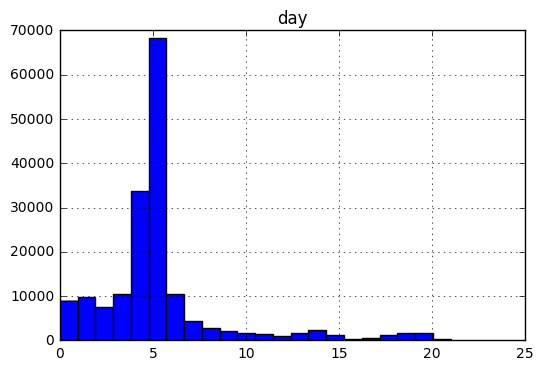

In [30]:
edges_df.hist(column='day', bins=22)

In [19]:
edges_df

,time,source,target,day
0,1318244928,35934,28197,0
1,1318244934,37953,59848,0
2,1318244938,36223,47353,0
3,1318244938,36223,10583,0
4,1318244939,33489,28197,0
5,1318244957,37591,52903,0
6,1318244961,39361,54059,0
7,1318244962,64210,28197,0
8,1318244966,50667,47309,0
9,1318244973,45236,29596,0


In [20]:
predicted_links

,day,source,target
0,1,58395,20696
1,1,49591,31688
2,1,33008,59848
3,1,66966,59848
4,1,13228,59848
5,1,44882,49189
6,1,38047,59848
7,1,44994,59848
8,1,23070,59848
9,1,10141,5273


## Kísérletek

In [65]:
talatok[talatok['day']==5]

,time,source,target,day
38,1318678548,7881,55250,5
39,1318678965,4892,55250,5
40,1318679591,24976,55250,5
41,1318682044,62239,55250,5
42,1318682244,17514,20696,5
43,1318682271,24658,55250,5
44,1318682602,32096,55250,5
45,1318683587,27542,55250,5
46,1318684311,37764,59848,5
47,1318684750,46096,59848,5


In [9]:
oneday = 86400
first = 1318244928
last = 1320072737

In [10]:
last-first

1827809

In [11]:
(last-first)/oneday

21.15519675925926

In [13]:
math.floor((last-first)/oneday)

21

In [101]:
true_positive_edges2 = pd.merge(edges_df, predicted_links, on=['day', 'source', 'target'], left_index=True)
indices = true_positive_edges2.index.values
false_positive_edges = predicted_links
false_positive_edges.drop(indices)

,day,source,target
0,1,58395,20696
1,1,49591,31688
2,1,33008,59848
3,1,66966,59848
4,1,13228,59848
5,1,44882,49189
6,1,38047,59848
7,1,44994,59848
8,1,23070,59848
9,1,10141,5273
